# Introduction to atomman: Running LAMMPS and the Log class

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction<a id='section1'></a>

This Notebook outlines the options of the atomman.lammps.Log class and the atomman.lammps.run() function.

**Library Imports**

In [1]:
# Standard libraries
import os
import glob
import time
import datetime

# http://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# https://github.com/usnistgov/atomman
import atomman as am            
import atomman.lammps as lmp
import atomman.unitconvert as uc

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.4.0
Notebook executed on 2021-08-05


## 2. Running LAMMPS<a id='section2'></a>

*Updated version 1.4.0:* Parameters updated to provide more running options and remove obsolete Log class-based parameters.  

The LAMMPS simulation can be ran from within Python using the run() function.  This runs LAMMPS as a subprocess, meaning that it can use any installed LAMMPS and MPI executables.

Parameters

- __lammps_command__ *(str*) The LAMMPS inline run command (sans -in script_name).
- __script_name__ *(str, optional*) Path of the LAMMPS input script file to use.  Either script_name or script must be given.
- __script__ *(str, optional*) The LAMMPS input script command lines to use.  Either script_name or script must be given.
- __mpi_command__ *(str or None, optional*) The MPI inline command to run LAMMPS in parallel. Default value is None (run serially).
- __restart_script_name__ *(str or None, optional*) Path to an alternate LAMMPS input script file to use for restart runs. If given, the restart script will be used if the specified logfile already exists.  Requires logfile to not be None.
- __restart_script__ (*str, optional*) Alternate LAMMPS script command lines to use for restart runs. If given, the restart script will be used if the specified logfile already exists.  Requires logfile to not be None.
- __logfile__ *(str or None, optional*) Specifies the path to the logfile to write to.  Default value is 'log.lammps'.  If set to None, then no logfile will be created.
- __screen__ *(bool, optional*) If True (default), then the resulting Log object is built from the LAMMPS screen output.  If False, then LAMMPS outputs no screen info and the Log object will be built by reading logfile.
- __suffix__ *(str, optional*) Allows for the LAMMPS suffix option to be specified to use any of the accelerated versions of pair styles if available.

Returns

- (*atomman.lammps.Log*) An object representation of the log.lammps file.

Create a simple demonstration LAMMPS input script

In [2]:
script = """
#Simple demonstration LAMMPS script

units metal
atom_style atomic
boundary p p p 

lattice fcc 3.52 origin 0.100000 0.100000 0.100000 
        
region box block 0 15 0 15 0 15
create_box 1 box
create_atoms 1 box

mass 1 58.71

pair_style lj/cut 6
pair_coeff 1 1 0.5408 2.272

velocity all create 100 2987532

thermo 100
thermo_style custom step pe temp press lx ly lz

restart 10000 *.restart

timestep 0.01

fix 1 all npt temp 100 100 1.0 aniso 0.0 0.0 10.0
run 10000

"""

Run in serial

In [3]:
# Define lammps command to use (unique to your computer!)
lammps_command = 'lmp_mpi'

# Run and measure execution time
start = time.time()
results = lmp.run(lammps_command, script=script)
end = time.time()
run_time = end-start

print(f"Serial simulation took {run_time} seconds.")

Serial simulation took 98.3661994934082 seconds.


Run in parallel on 4 processors

In [4]:
# Define lammps command to use (unique to your computer!)
lammps_command = 'lmp_mpi'

# Define mpi command to use (unique to your computer!)
mpi_command = 'C:/Program Files/MPICH2/bin/mpiexec.exe -localonly 4'

# Run and measure execution time
start = time.time()
results = lmp.run(lammps_command, script=script, mpi_command=mpi_command)
end = time.time()
run_time = end-start

print(f"Parallel simulation took {run_time} seconds.")

Parallel simulation took 47.57556772232056 seconds.


## 3. Accessing results with Log class<a id='section3'></a>

*Updated version 1.3.7*: now captures performance output.  A Simulation class is added to better represent each run/simulation.  The flatten method is updated to return a new Simulation rather than overwriting the current data.  New 'all' style added to flatten that will merge all runs without filtering out duplicate timesteps. 

Information from the log.lammps file(s) is automatically parsed by the run() function and returned as an atomman.lammps.Log object.  Currently, the Log class stores the following information:

- **lammps_version** (*str*) The LAMMPS version used.
- **lammps_date** (*datetime.date*) The date associated with the LAMMPS version.
- **simulations** (*list*) information for each simulation (run, minimize ...) that was executed.

In [5]:
print("results.lammps_version ->", results.lammps_version)
print("results.lammps_date ->", results.lammps_date)

results.lammps_version -> 3 Mar 2020
results.lammps_date -> 2020-03-03


Each simulation captures the associated thermo data lines and the computational performance data in separate pandas.DataFrames.

In [6]:
results.simulations[0].thermo.keys()

Index(['Step', 'PotEng', 'Temp', 'Press', 'Lx', 'Ly', 'Lz'], dtype='object')

In [7]:
results.simulations[0].performance

,min time,avg time,max time,%varavg,%total
Section,,,,,
Pair,24.363000,24.627000,24.884000,5.0,88.57
Neigh,0.005595,0.005656,0.005722,0.1,0.02
Comm,1.087600,1.347400,1.616000,21.7,4.85
Output,0.010593,0.010796,0.011395,0.3,0.04
Modify,1.530100,1.533900,1.536700,0.2,5.52
Other,0.000000,0.281500,0.000000,0.0,1.01


This makes it very easy to plot the simulation thermo data

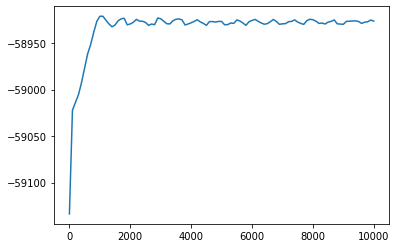

In [8]:
for simulation in results.simulations:
    plt.plot(simulation.thermo.Step, simulation.thermo.PotEng)
plt.show()

## 4. Restarting and flattening<a id='section4'></a>

There is also some built-in functionality for conveniently handling simulations containing multiple runs and/or multiple sequential simulation executions of the same overall run (i.e. restarts).

### 4.1. Running with restart script included

Create a new demonstration LAMMPS input script that restarts the previous simulation and runs for an additional 10000 steps.

In [10]:
restart_script = """
#Simple demonstration LAMMPS restart script

read_restart *.restart

mass 1 58.71

pair_style lj/cut 6
pair_coeff 1 1 0.5408 2.272

thermo 100
thermo_style custom step pe temp press lx ly lz

restart 10000 *.restart

fix 1 all npt temp 100 100 1.0 aniso 0.0 0.0 10.0
run 10000

"""

Now, if we call run() with either restart_script_name or restart_script set, a number of cool things happen:

- If logfile (default log.lammps) does not exist in the working directory then the regular script is passed to LAMMPS./
- If logfile does exist then it is moved from NAME.EXT to NAME-&ast;.EXT, where &ast; is the smallest integer not already there, and the restart script is passed to LAMMPS.
- Upon completion, the data in NAME.EXT logfile and all NAME-&ast;.EXT logfiles are automatically read in by the Log object.

In [11]:
for i in range(3):
    results = lmp.run(lammps_command, script=script, mpi_command=mpi_command, restart_script=restart_script)

Show all log files in the run directory

In [12]:
for logfile in glob.iglob('*.lammps'):
    print(logfile)

log-1.lammps
log-2.lammps
log-3.lammps
log.lammps


Show that results now has two simulations, one for steps 0 to 10000 and one for steps 10000 to 20000 (the restart)

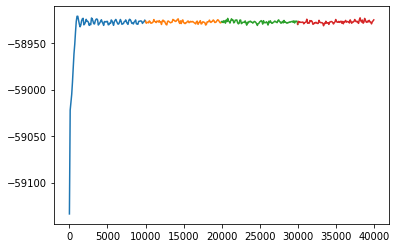

In [13]:
for simulation in results.simulations:
    plt.plot(simulation.thermo.Step, simulation.thermo.PotEng)
plt.show()

### 4.2. Flattening data from multiple simulations together

*Changed version 1.3.7* flatten now returns a new Simulation rather than overwriting the current content.

The Log.flatten() method creates a new Simulation object that combines the thermo data from all of the simulations.  flatten takes a single parameter that specifies how thermo lines with duplicate timesteps are treated:

- 'last' (default) will use values for each timestep from the last runs where they appear.  This is useful for MD restart runs where thermo data from eariler runs may be incomplete if externally stopped.
- 'first' will use values for each timestep from the first runs where they appear.  This is useful for quasistatic simulations where minimizations are performed under different conditions and only the final relaxed state of each condition is important.
- 'all' will use all thermo lines from all simulations including ones with the same timesteps.  This is useful for "run 0" simulations of different conditions, or if the timestep is reset. 

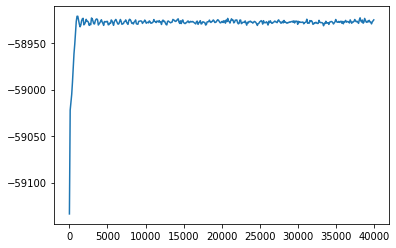

In [14]:
allsims = results.flatten('last')
plt.plot(allsims.thermo.Step, allsims.thermo.PotEng)
plt.show()

Note that only thermo data is included in the merged simulation and not the performance data.

In [15]:
repr(allsims.performance)

'None'

## 5. Error messages<a id='section5'></a>

*LAMMPSError added and error handling improved version 1.3.2*

To assist in running LAMMPS simulations, a LAMMPSError error type is defined which does its best to extract the error message that LAMMPS issues as a Python error. 

In [16]:
# Create a demo script with an error: missing a value in the fix npt line
bad_script = """
#Simple demonstration LAMMPS script

units metal
atom_style atomic
boundary p p p 

lattice fcc 3.52 origin 0.100000 0.100000 0.100000 
        
region box block 0 15 0 15 0 15
create_box 1 box
create_atoms 1 box

mass 1 58.71

pair_style lj/cut 6
pair_coeff 1 1 0.5408 2.272

velocity all create 100 2987532

thermo 100
thermo_style custom step pe temp press lx ly lz

restart 10000 *.restart

timestep 0.01

fix 1 all npt temp 100 100 1.0 aniso 0.0 0.0 
run 10000

"""

In [17]:
try:
    results = lmp.run(lammps_command, script=bad_script, mpi_command=mpi_command)
except Exception as ex:
    print(type(ex).__name__, 'raised with message')
    print(ex.args[0])   

LammpsError raised with message
Illegal fix nvt/npt/nph command (../fix_nh.cpp:153)
Last command: fix 1 all npt temp 100 100 1.0 aniso 0.0 0.0



**File Cleanup**

In [18]:
os.remove('log.lammps')
for restart in glob.iglob('*.restart'):
    os.remove(restart)
for restart in glob.iglob('log-*.lammps'):
    os.remove(restart)